## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
# cd ..
%cd /home/jovyan/dea_intertidal/dea-intertidal

/home/jovyan/dea_intertidal/dea-intertidal


Install additional packages directly from the requirements file

In [2]:
pip install -r requirements.in --quiet

Note: you may need to restart the kernel to use updated packages.


### Load packages

In [14]:
%load_ext autoreload
%autoreload 2

import datacube
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from datacube.utils.cog import write_cog
from datacube.utils.geometry import Geometry
import odc.geo.xr
from tqdm import tqdm
from odc.algo import mask_cleanup, xr_quantile
from concurrent.futures import ProcessPoolExecutor

from dea_tools.dask import create_local_dask_cluster
from dea_tools.coastal import pixel_tides, model_tides
from intertidal.elevation import (load_data, 
                                  ds_to_flat, 
                                  pixel_rolling_median,
                                  pixel_dem,
                                  elevation
                                 )
from intertidal.extents import extents
from intertidal.utils import load_config
from intertidal.exposure import pixel_exp
from intertidal.tidal_bias_offset import bias_offset
from intertidal.tidelines import tidal_offset_tidelines

# cluster = create_dask_gateway_cluster(profile="r5_4XL", workers=10)
# print("Dashboard", cluster.dashboard_link)
# client = cluster.get_client()

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

# Connect to datacube
dc = datacube.Datacube(app='Intertidal_elevation')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/claire.phillips@ga.gov.au/proxy/38311/status,
Dashboard: /user/claire.phillips@ga.gov.au/proxy/38311/status,Workers: 1
Total threads: 62,Total memory: 477.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46287,Workers: 1
Dashboard: /user/claire.phillips@ga.gov.au/proxy/38311/status,Total threads: 62
Started: Just now,Total memory: 477.21 GiB
Comm: tcp://127.0.0.1:34255,Total threads: 62
Dashboard: /user/claire.phillips@ga.gov.au/proxy/36763/status,Memory: 477.21 GiB
Nanny: tcp://127.0.0.1:38177,


## Setup


### Set analysis parameters

In [9]:
study_area = 'Gladstone'#1215 #340
## 815: South Gladstone, QLD 

## Nidem variables
fname = 'testing_Gladstone'
start_year = 2019
end_year = 2021
resolution = 10 
crs = "epsg:32753"
ndwi_thresh = 0.1
include_s2 = True
include_ls = True
filter_gqa = False
## Exposure variables
## Set the frequency to run the tidal model e.g '30min' or '1h'
modelled_freq='30min'

# Generate range of times covering entire period of satellite record for exposure and bias/offset calculation
all_timerange = pd.date_range(start = f'{start_year}-01-01 00:00:00',
                              # start=time_start,
                              # end=time_end,
                              end = f'{end_year}-12-31 00:00:00',
                              freq=modelled_freq)

# Load analysis params from config file
config = load_config(
    config_path='configs/dea_intertidal_config.yaml')

### Load study area grid cell

In [10]:
# # Albers grid cells used to process the analysis
# gridcell_gdf = (
#     gpd.read_file(config['Input files']['grid_path']).to_crs(
#         epsg=4326).set_index('id'))
# gridcell_gdf.index = gridcell_gdf.index.astype(int).astype(str)
# gridcell_gdf = gridcell_gdf.loc[[str(study_area)]]

# # Create geom as input for dc.load
# geom = Geometry(geom=gridcell_gdf.iloc[0].geometry, crs='EPSG:4326')
# geom

##### Other options for loading study area

In [11]:
# # aoi = 'McCarthur River'
# # aoi = 'Greenbank'
# aoi = 'Seven Emu'
# # aoi = 'Wollogorang'

# # Import regions of interest
# aoi_gdf = gpd.read_file('data/raw/Phase_1_NT_Gov.geojson').set_index('Name').to_crs('EPSG:3577')
# aoi_gdf.head()

# # Select AOI
# geom = Geometry(geom=aoi_gdf.loc[aoi].geometry, crs='EPSG:3577')
# geom

In [12]:
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geom = select_on_a_map(height='600px',
                             layers=(basemap,),
                             center=(-26, 135), 
                       
                             zoom=4)

## Guide: for 10m2 pixels, analysis area of 90km2 takes ~XXXX mins to run full workflow on 16XL sandbox instance

Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

# Elevation

In [15]:
ds, freq = elevation(study_area=geom,
                   start_year = start_year,
                   end_year = end_year)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/claire.phillips@ga.gov.au/proxy/39157/status,
Dashboard: /user/claire.phillips@ga.gov.au/proxy/39157/status,Workers: 1
Total threads: 62,Total memory: 477.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:32939,Workers: 1
Dashboard: /user/claire.phillips@ga.gov.au/proxy/39157/status,Total threads: 62
Started: Just now,Total memory: 477.21 GiB
Comm: tcp://127.0.0.1:43447,Total threads: 62
Dashboard: /user/claire.phillips@ga.gov.au/proxy/39833/status,Memory: 477.21 GiB
Nanny: tcp://127.0.0.1:40439,


2023-04-03 04:17:13 INFO Study area testing: Loaded custom study area
2023-04-03 04:17:13 INFO Study area testing: Loading satellite data
2023-04-03 04:18:30 INFO Study area testing: Modelling tide heights for each pixel


Creating reduced resolution tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 571/571 [00:01<00:00, 528.46it/s]
2023-04-03 04:18:44 INFO Study area testing: Masking nodata and adding tide heights to satellite data array
2023-04-03 04:18:45 INFO Study area testing: Flattening satellite data array and filtering to tide influenced pixels
2023-04-03 04:18:48 INFO Study area testing: Running per-pixel rolling median


Reducing analysed pixels from 175856 to 34289 (19.50%)


100%|██████████| 114/114 [00:46<00:00,  2.46it/s]
2023-04-03 04:19:37 INFO Study area testing: Modelling intertidal elevation and confidence


Processing dem_low
Processing dem
Processing dem_high


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-04-03 04:19:39 INFO Study area testing: Successfully completed intertidal elevation modelling


# Intertidal extents

## Always/Sometimes/Never_wet

Values of 0 represent always wet, 1 is the extent of the DEA intertidal product suite and 2 represents never wet

In [16]:
ds['extents'] = extents(freq, ds.dem)

# Pixel-based intertidal exposure
Calculate exposure using the script function

In [20]:
tide_cq, ds['exposure'] = pixel_exp(ds, ds.dem, all_timerange)

Creating reduced resolution tide modelling array
Modelling tides using FES2014 tide model
Computing tide quantiles
Reprojecting tides into original array


100%|██████████| 101/101 [00:00<00:00, 263.61it/s]


# Spread and offset
Calculate the spread and high/low tide biases of input observed images as a percentage of the modelled tide heights

In [24]:
(ds['lat'],
 ds['hat'],
 ds['lot'],
 ds['hot'],
 ds['spread'],
 ds['lt_offset'],
 ds['ht_offset']) = bias_offset(tide_m = ds.tide_m,
                                tide_cq = tide_cq,
                                extents = ds.extents,
                                lot_hot=True,
                                lat_hat=True)

# Tideline confidence

In [25]:
(hightideline, 
 lowtideline, 
 tidelines_gdf) = tidal_offset_tidelines(extents = ds.extents,
                                         ht_offset = ds.ht_offset,
                                         lt_offset = ds.lt_offset,
                                         distance=250)

Operating in multiple z-value, single array mode


# Plot all layers

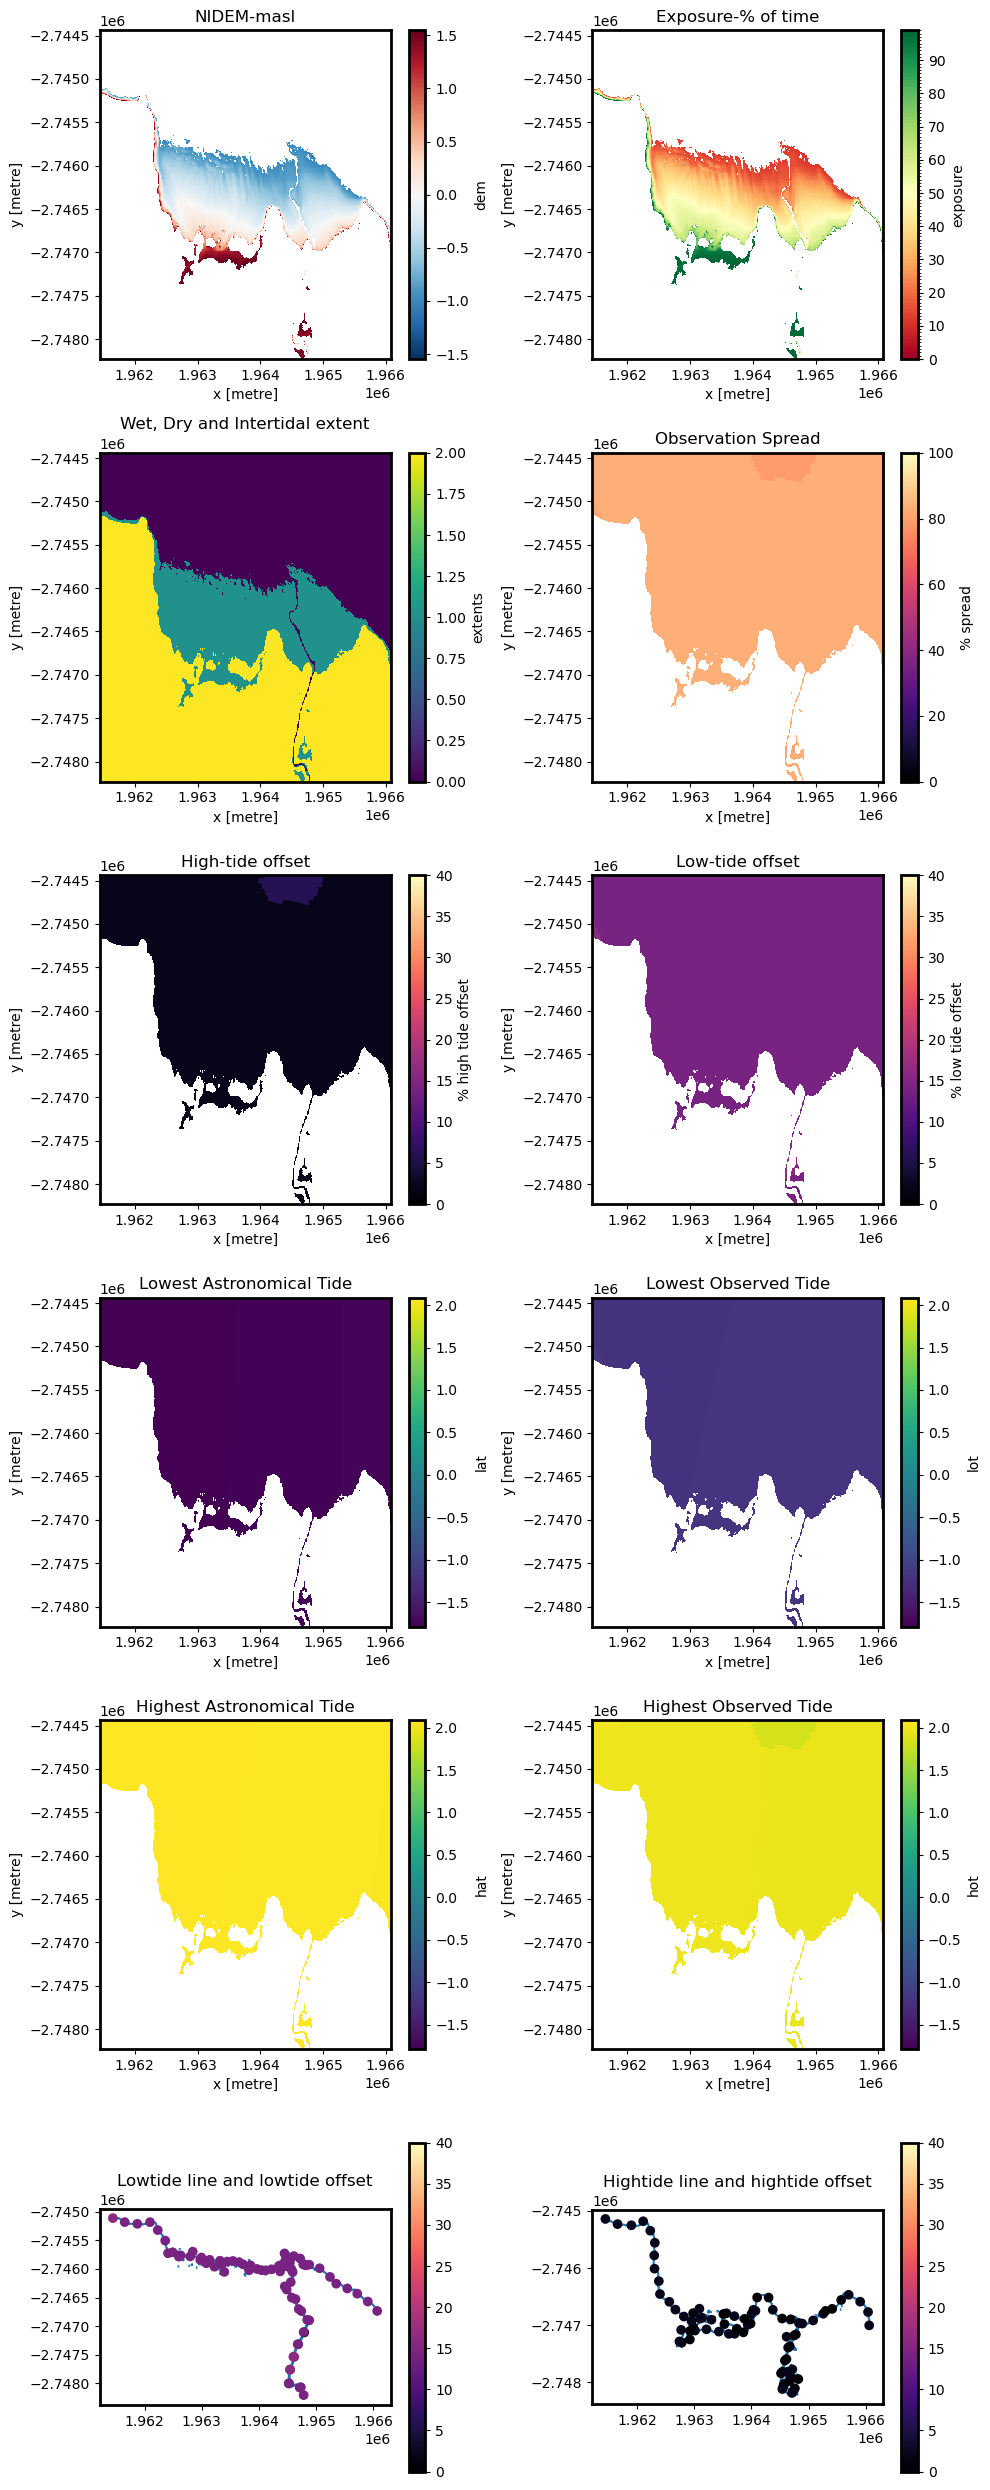

In [26]:
fig = plt.figure(figsize=(10,25))
ax1 = fig.add_subplot(6,2,1)
ax2 = fig.add_subplot(6,2,2)
ax3 = fig.add_subplot(6,2,3)
ax4 = fig.add_subplot(6,2,4)
ax5 = fig.add_subplot(6,2,5)
ax6 = fig.add_subplot(6,2,6)
ax7 = fig.add_subplot(6,2,7)
ax8 = fig.add_subplot(6,2,8)
ax9 = fig.add_subplot(6,2,9)
ax10 = fig.add_subplot(6,2,10)
ax11 = fig.add_subplot(6,2,11)
ax12 = fig.add_subplot(6,2,12)

## Plot NIDEM
ds['dem'].plot(ax=ax1)
ax1.set_title('NIDEM-masl')

## Plot Exposure
ds['exposure'].where(ds['exposure']>0).plot(ax=ax2, cmap='RdYlGn', levels=np.arange(0,100,1))
ax2.set_title('Exposure-% of time')

## Plot the always/sometimes/never wet extents
ds['extents'].astype(np.int16).plot(ax=ax3)
ax3.set_title('Wet, Dry and Intertidal extent')

## Plot the observation spread
ds['spread'].where((ds['extents']!=2) & (ds['spread'] > 0)).plot(ax=ax4, vmin=0, vmax=100, cmap='magma', cbar_kwargs={'label': '% spread'})
ax4.set_title('Observation Spread')

## Plot the high-tide offset
ds['ht_offset'].where((ds['extents']!=2) & (ds['spread'] > 0)).plot(ax=ax5, vmin=0, vmax=40, cmap='magma', cbar_kwargs={'label': '% high tide offset'})
ax5.set_title('High-tide offset')

## Plot the low-tide offset
ds['lt_offset'].where((ds['extents']!=2) & (ds['spread'] > 0)).plot(ax=ax6, vmin=0, vmax=40, cmap='magma', cbar_kwargs={'label': '% low tide offset'})
ax6.set_title('Low-tide offset')

## Plot the LAT
ds['lat'].where(ds['extents']!=2).plot(ax=ax7, vmin=ds['lat'].min(), vmax=ds['hat'].max())
ax7.set_title('Lowest Astronomical Tide')

## Plot the LOT
ds['lot'].where(ds['extents']!=2).plot(ax=ax8, vmin=ds['lat'].min(), vmax=ds['hat'].max())
ax8.set_title('Lowest Observed Tide')

## Plot the HAT
ds['hat'].where(ds['extents']!=2).plot(ax=ax9, vmin=ds['lat'].min(), vmax=ds['hat'].max())
ax9.set_title('Highest Astronomical Tide')

## Plot the HOT
ds['hot'].where(ds['extents']!=2).plot(ax=ax10, vmin=ds['lat'].min(), vmax=ds['hat'].max())
ax10.set_title('Highest Observed Tide')

## Plot the high and low tidelines with respective offset
ax11.set_title('Lowtide line and lowtide offset')
lowtideline.plot(column='lt_offset', legend=True, vmin=0, vmax=40, cmap='magma', ax=ax11, zorder=2)
tidelines_gdf.loc[[0], 'geometry'].plot(ax=ax11, zorder=1)

ax12.set_title('Hightide line and hightide offset')
hightideline.plot(column='ht_offset', legend=True, vmin=0, vmax=40, cmap='magma', ax=ax12, zorder=2)
tidelines_gdf.loc[[1], 'geometry'].plot(ax=ax12, zorder=1)

fig.tight_layout()
plt.show()

# plt.savefig(f'data/interim/{fname}.png') ## doesn't seem to work

# Export layers

In [ ]:
## select layers of interest from ds
ds1 = xr.Dataset(data_vars = ds[['dem','confidence','extents','exposure','spread','lt_offset','ht_offset','lat','hat','lot','hot']],
                coords = ds.coords,
                attrs = ds.attrs)

## Save layers as geotiffs
ds1.map(
    lambda x: x.odc.write_cog(
        fname=f"data/interim/pixel_{fname}_{start_year}_{end_year}_{x.name}.tif", overwrite=True
    )
) 

hightideline.to_file(f'data/interim/{fname}_hightideoffset.shp')
lowtideline.to_file(f'data/interim/{fname}_lowtideoffset.shp')
tidelines_gdf.to_file(f'data/interim/{fname}_high_low_tidelines.shp')

In [90]:
import fiona
from fiona.crs import to_string
from shapely.geometry import mapping

schema = {
    'geometry': 'Polygon',
    'properties':{'id':'int'}
    }
## Note: open shp and set crs as epsg:4326 in QGIS
with fiona.open(f'./data/interim/{fname}_geom',
                'w', 
                'ESRI Shapefile', 
                schema,
                # crs=geom.crs.crs_str
               ) as c:
    c.write({'geometry': mapping(geom.geom),
             'properties':{'id':123},
             'crs' : geom.crs
            })